<a href="https://colab.research.google.com/github/MosheWasserb/BestPracticeTextClassificationDistillation/blob/main/SimilaritySearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import pandas as pd
import numpy as np
import random
import torch

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [ ]:
!pip install datasets

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Oct 15 08:37:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# GLUE one sentence classification

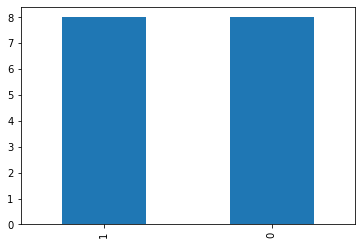

In [ ]:
#SST-2
# Load the dataset into a pandas dataframe.

train_df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

# Load the test dataset into a pandas dataframe.
test_df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/test.tsv', delimiter='\t', header=None)

set_seed(42)


# Sample by class 
train_df_sample = pd.concat([train_df[train_df[1]==0].sample(8), train_df[train_df[1]==1].sample(8)])
#train_df_sample = train_df.sample(500)

text_col=train_df.columns.values[0] 
category_col=train_df.columns.values[1]

x_train = train_df_sample[text_col].values.tolist()
x_test = test_df[text_col].values.tolist()

y_train = train_df_sample[category_col].values.tolist()
y_test = test_df[category_col].values.tolist()

#train_df_GLUE = pd.read_csv('/gdrive/My Drive/DataSet/GLUE/SST-2/SST-2/train.tsv', delimiter='\t')
#x_train_GLUE = train_df_GLUE.sentence.values.tolist()
#y_train_GLUE = train_df_GLUE.label.values.tolist()

train_df_unlabel_sample = train_df.sample(6920)
x_train_unlabel = train_df_unlabel_sample[text_col].values.tolist()
y_train_unlabel = train_df_unlabel_sample[category_col].values.tolist()

train_df_sample[category_col].value_counts().plot.bar()

     |████████████████████████████████| 270 kB 4.2 MB/s 
     |████████████████████████████████| 125 kB 43.6 MB/s 
     |████████████████████████████████| 243 kB 47.6 MB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 
     |████████████████████████████████| 1.3 MB 40.8 MB/s 
     |████████████████████████████████| 271 kB 51.8 MB/s 
     |████████████████████████████████| 160 kB 39.7 MB/s 


Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

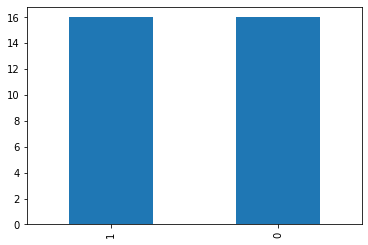

In [ ]:
#IMDB
!pip install datasets
from datasets import load_dataset
import pandas as pd

imdb_dataset = load_dataset('imdb')
shuffled_imdb_dataset = imdb_dataset.shuffle(seed=42)

train_df = pd.DataFrame(list(zip(shuffled_imdb_dataset['train']['text'], shuffled_imdb_dataset['train']['label'])), 
               columns =['text', 'label'])

test_df = pd.DataFrame(list(zip(shuffled_imdb_dataset['test']['text'], shuffled_imdb_dataset['test']['label'])), 
               columns =['text', 'label'])

eval_df = pd.DataFrame(list(zip(shuffled_imdb_dataset['unsupervised']['text'], shuffled_imdb_dataset['unsupervised']['label'])), 
               columns =['text', 'label'])

set_seed(42)
# Display 10 random rows from the data.
#train_df_sample=train_df.sample(32)
train_df_sample = pd.concat([train_df[train_df.label==0].sample(16), train_df[train_df.label==1].sample(16)])

x_train = train_df_sample.text.values.tolist()
y_train = train_df_sample.label.values

x_test = test_df.text.values.tolist()
y_test = test_df.label.values

train_df_unlabel_sample = eval_df.sample(500)
x_train_unlabel = train_df_unlabel_sample.text.values.tolist()
y_train_unlabel = train_df_unlabel_sample.label.values.tolist()

train_df_sample.label.value_counts().plot.bar()

# Double sentence classification

In [ ]:
#BoolQ
import pandas as pd

!pip install datasets
from datasets import load_dataset
import pandas as pd

boolq_dataset = load_dataset('boolq')

train_df = pd.DataFrame(list(zip(boolq_dataset['train']['answer'], boolq_dataset['train']['passage'], boolq_dataset['train']['question'])), 
               columns =['label', 'q1', 'q2'])

test_df = pd.DataFrame(list(zip(boolq_dataset['validation']['answer'], boolq_dataset['validation']['passage'], boolq_dataset['validation']['question'])), 
               columns =['label', 'q1', 'q2'])

set_seed(42)

# Sample by class 
train_df_sample = pd.concat([train_df[train_df['label']==0].sample(16), train_df[train_df['label']==1].sample(16)])

x_train_q1 = train_df_sample.q1.values
x_train_q2 = train_df_sample.q2.values
x_train_q1_q2 = np.concatenate((x_train_q1, x_train_q2), axis=0)

train_df_sample.q1=train_df_sample.q1.apply(lambda x: ' '.join(x.split(' ')[:128]))

# Get the lists of sentences and their labels.
x_train = train_df_sample.q1.values+'.'+train_df_sample.q2.values
y_train = train_df_sample.label.values

test_df.q1=test_df.q1.apply(lambda x: ' '.join(x.split(' ')[:128]))

x_test_q1 = test_df.q1.values
x_test_q2 = test_df.q2.values
x_test_q1_q2 = np.concatenate((x_test_q1,x_test_q2), axis=0)

x_test = test_df.q1.values+'.'+test_df.q2.values
y_test = test_df.label.values


train_df_unlabel_sample = train_df.sample(500)
x_train_unlabel = train_df_unlabel_sample.q1.values+' '+train_df_unlabel_sample.q2.values
y_train_unlabel = train_df_unlabel_sample.label.values.tolist()

train_df_sample.label.value_counts().plot.bar()

#  RAFT Dataset loader

In [ ]:
# RAFT

#https://huggingface.co/datasets/ought/raft-submission
#https://colab.research.google.com/drive/1TQtHG-Wf2CgYGSD9e7_uJWIdiK5HNniV#scrollTo=iiNc1mbMO7Wy
!pip install datasets
from datasets import load_dataset, get_dataset_config_names
import pandas as pd

RAFT_TASKS = get_dataset_config_names("ought/raft")
RAFT_TASKS

Downloading:   0%|          | 0.00/11.9k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/56.1k [00:00<?, ?B/s]

['ade_corpus_v2',
 'banking_77',
 'terms_of_service',
 'tai_safety_research',
 'neurips_impact_statement_risks',
 'overruling',
 'systematic_review_inclusion',
 'one_stop_english',
 'tweet_eval_hate',
 'twitter_complaints',
 'semiconductor_org_types']

['ade_corpus_v2': ade_corpus_v2 = load_dataset('ade_corpus_v2', 'Ade_corpus_v2_classification'),
 'banking_77',
 'terms_of_service',
 'tai_safety_research',
 'neurips_impact_statement_risks',
 'overruling',
 'systematic_review_inclusion',
 'one_stop_english',
 'tweet_eval_hate',
 'twitter_complaints',
 'semiconductor_org_types']

ADE 

Reusing dataset raft (/root/.cache/huggingface/datasets/ought___raft)/ade_corpus_v2/1.1.0/79c4de1312c1e3730043f7db07179c914f48403101f7124e2fe336f6f54d9f84)


  0%|          | 0/2 [00:00<?, ?it/s]

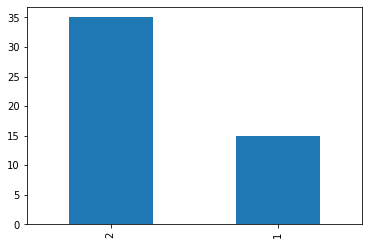

In [ ]:
# ADE Fewshot training

task = 'ade_corpus_v2'

ade_dataset = load_dataset("ought/raft", task)


train_df = pd.DataFrame(list(zip(ade_dataset['train']['Sentence'], ade_dataset['train']['Label'])), 
               columns =['Sentence', 'Label'])

test_df = pd.DataFrame(list(zip(ade_dataset['test']['Sentence'], ade_dataset['test']['ID'], ade_dataset['test']['Label'])), 
               columns =['Sentence', 'ID', 'Label'])

#train_df_sample = pd.concat([train_df[train_df.Label==2].sample(15), train_df[train_df.Label==1].sample(15)])
train_df_sample = train_df

x_train = train_df_sample.Sentence.values.tolist()
#train_df_sample.Label=train_df_sample.Label.replace(2,0)
y_train = train_df_sample.Label.values

x_test = test_df.Sentence.values.tolist()

train_df_sample.Label.value_counts().plot.bar()


In [ ]:
ade_dataset

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'ID', 'Label'],
        num_rows: 50
    })
    test: Dataset({
        features: ['Sentence', 'ID', 'Label'],
        num_rows: 5000
    })
})

Reusing dataset ade_corpus_v2 (/root/.cache/huggingface/datasets/ade_corpus_v2/Ade_corpus_v2_classification/1.0.0/940d61334dbfac6b01ac5d00286a2122608b8dc79706ee7e9206a1edb172c559)


  0%|          | 0/1 [00:00<?, ?it/s]

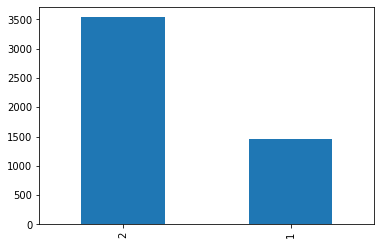

In [ ]:
# ADE Evaluation
ade_corpus_v2 = load_dataset('ade_corpus_v2', 'Ade_corpus_v2_classification')
ade_corpus_v2_df = pd.DataFrame(list(zip(ade_corpus_v2['train']['text'], ade_corpus_v2['train']['label'])), 
               columns =['text', 'label'])
ade_corpus_v2_df_sample=ade_corpus_v2_df.sample(5000)
x_eval = ade_corpus_v2_df_sample.text.values.tolist()
ade_corpus_v2_df_sample.label=ade_corpus_v2_df_sample.label.replace(0,2)
y_eval = ade_corpus_v2_df_sample.label.values.tolist()

ade_corpus_v2_df_sample.label.value_counts().plot.bar()

Banking77

Reusing dataset raft (/root/.cache/huggingface/datasets/ought___raft)/banking_77/1.1.0/79c4de1312c1e3730043f7db07179c914f48403101f7124e2fe336f6f54d9f84)


  0%|          | 0/2 [00:00<?, ?it/s]

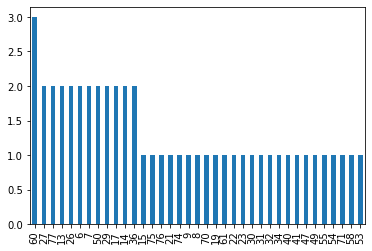

In [ ]:
b77_dataset = load_dataset("ought/raft", "banking_77")

train_df = pd.DataFrame(list(zip(b77_dataset['train']['Query'], b77_dataset['train']['Label'])), 
               columns =['text', 'label'])

test_df = pd.DataFrame(list(zip(b77_dataset['test']['Query'], b77_dataset['test']['Label'])), 
               columns =['text', 'label'])

x_train = train_df.text.values.tolist()
y_train = train_df.label.values.tolist()

x_test = test_df.text.values.tolist()

train_df.label.value_counts().plot.bar()

In [ ]:
#Load Intent catagory 
b77_cat_df = pd.read_csv('/gdrive/My Drive/DataSet/FART/B77/b77_cat_test.csv')

x_b77 = b77_cat_df.intent.values.tolist()
y_b77 = b77_cat_df.label.values.tolist()

In [ ]:
x_train = x_train + x_b77
y_train = y_train+ y_b77

In [ ]:
#https://analyticsindiamag.com/how-to-paraphrase-text-using-pegasus-transformer/

In [ ]:
#B77 evaluation
#banking77_dataset =  load_dataset('banking77')

#train_df = pd.DataFrame(list(zip(banking77_dataset['train']['text'], banking77_dataset['train']['label'])), 
#               columns =['text', 'label'])

#eval_df = pd.DataFrame(list(zip(banking77_dataset['test']['text'], banking77_dataset['test']['label'])), 
#               columns =['text', 'label'])

#test_df.text=test_df.text.apply(lambda x: ' '.join(x.split(' ')[:128]))


#train_df_sample=train_df.sample(50)

#x_train = train_df_sample.text.values.tolist()
#y_train = train_df_sample.label.values.tolist()

#x_eval = eval_df.text.values.tolist()
#y_eval = eval_df.label.values.tolist()

#eval_df.label.value_counts().plot.bar()


In [ ]:
b77_eval_df = pd.read_csv('/gdrive/My Drive/DataSet/FART/B77/b77_eval_update.csv')

x_eval = b77_eval_df.text.values.tolist()
y_eval = b77_eval_df.label.values.tolist()


NeurIPS imapcy statement risks (NIS)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset raft downloaded and prepared to /root/.cache/huggingface/datasets/ought___raft)/neurips_impact_statement_risks/1.1.0/79c4de1312c1e3730043f7db07179c914f48403101f7124e2fe336f6f54d9f84. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

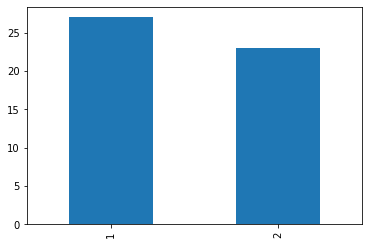

In [ ]:
#NIS - Fewshot training
# Consider adding num wof words in a sentence as secondery feature 

nis_dataset = load_dataset("ought/raft", "neurips_impact_statement_risks")

train_df = pd.DataFrame(list(zip(nis_dataset['train']['Paper title'],nis_dataset['train']['Impact statement'], nis_dataset['train']['Label'])), 
               columns =['text1', 'text2', 'label'])

test_df = pd.DataFrame(list(zip(nis_dataset['test']['Paper title'], nis_dataset['test']['Impact statement'],  nis_dataset['test']['Label'])), 
               columns =['text1', 'text2' ,'label'])

train_df.text2=train_df.text2.apply(lambda x: ' '.join(x.split(' ')[-128::]))

x_train = train_df.text2.values.tolist()
y_train = train_df.label.values

test_df.text2=test_df.text2.apply(lambda x: ' '.join(x.split(' ')[-128::]))
x_test = test_df.text2.values.tolist()

train_df.label.value_counts().plot.bar()


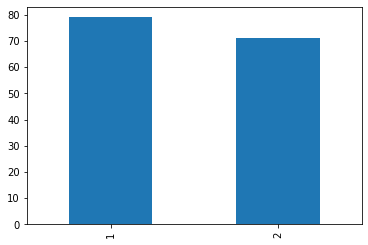

In [ ]:
#NIS Evaluation 

eval_df = pd.read_csv('/gdrive/My Drive/DataSet/FART/NIS/nis_test.csv')

eval_df.text2=eval_df.text2.apply(lambda x: ' '.join(x.split(' ')[-128::]))

x_eval = eval_df.text2.values.tolist()
y_eval = eval_df.label.values

eval_df.label.value_counts().plot.bar()


OneStopEnglish

Reusing dataset raft (/root/.cache/huggingface/datasets/ought___raft)/one_stop_english/1.1.0/79c4de1312c1e3730043f7db07179c914f48403101f7124e2fe336f6f54d9f84)


  0%|          | 0/2 [00:00<?, ?it/s]

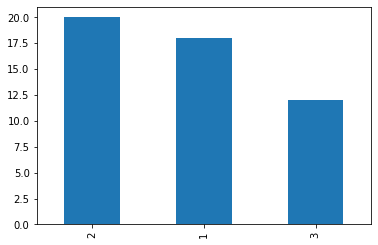

In [ ]:
#OneStopEnglish - Fewshot training

ose_dataset = load_dataset("ought/raft", "one_stop_english")

train_df = pd.DataFrame(list(zip(ose_dataset['train']['Article'], ose_dataset['train']['Label'])), 
               columns =['text', 'label'])

test_df = pd.DataFrame(list(zip(ose_dataset['test']['Article'], ose_dataset['test']['Label'])), 
               columns =['text', 'label'])

train_df.text=train_df.text.apply(lambda x: ' '.join(x.split(' ')[:128]))

x_train = train_df.text.values.tolist()

y_train = train_df.label.values

x_test = test_df.text.values.tolist()

train_df.label.value_counts().plot.bar()

Using custom data configuration default
Reusing dataset onestop_english (/root/.cache/huggingface/datasets/onestop_english/default/1.1.0/6b19eec5680862ad1cf1990e98b06a98d1fa4c85f3585dc4dfab93f52b89d9cf)


  0%|          | 0/1 [00:00<?, ?it/s]

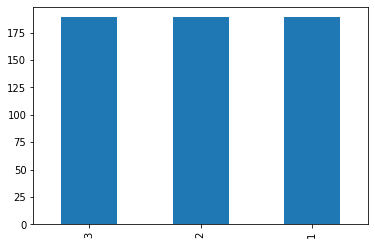

In [ ]:
#OneStopEnglish - Evaluation
onestop_english =  load_dataset('onestop_english')

eval_df = pd.DataFrame(list(zip(onestop_english['train']['text'], onestop_english['train']['label'])), 
               columns =['text', 'label'])

eval_df.text=eval_df.text.apply(lambda x: ' '.join(x.split(' ')[:128]))

eval_df.label=eval_df.label.replace([2,0,1], [1,2,3])

x_eval = eval_df.text.values.tolist()
y_eval = eval_df.label.values

eval_df.label.value_counts().plot.bar()


Overruling

Reusing dataset raft (/root/.cache/huggingface/datasets/ought___raft)/overruling/1.1.0/79c4de1312c1e3730043f7db07179c914f48403101f7124e2fe336f6f54d9f84)


  0%|          | 0/2 [00:00<?, ?it/s]

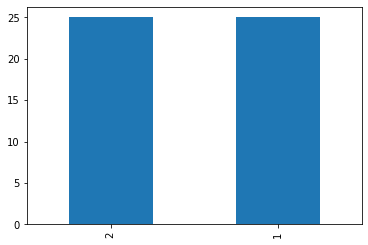

In [ ]:
#Overruling - Fewshot training

over_dataset = load_dataset("ought/raft", "overruling")

train_df = pd.DataFrame(list(zip(over_dataset['train']['Sentence'], over_dataset['train']['Label'])), 
               columns =['Sentence', 'Label'])

test_df = pd.DataFrame(list(zip(over_dataset['test']['Sentence'], over_dataset['test']['Label'])), 
               columns =['Sentence', 'Label'])


train_df_sample = train_df

x_train = train_df_sample.Sentence.values.tolist()
#train_df_sample.Label=train_df_sample.Label.replace(1,0)
#train_df_sample.Label=train_df_sample.Label.replace(2,1)
y_train = train_df_sample.Label.values

x_test = test_df.Sentence.values.tolist()
#test_df.Label=test_df.Label.replace(1,1)

train_df_sample.Label.value_counts().plot.bar()

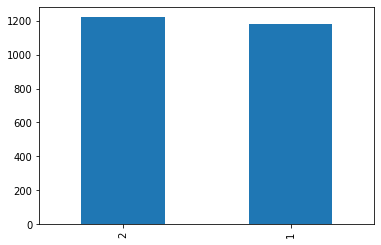

In [ ]:
#Overruling - Evaluation

eval_df = pd.read_csv('/gdrive/My Drive/DataSet/FART/Overruling/overruling.csv')
eval_df.drop(test_df.index[[0]])

eval_df.label=eval_df.label.replace([0,1],[1,2])

x_eval = eval_df.sentence1.values.tolist()
y_eval = eval_df.label.values

eval_df.label.value_counts().plot.bar()

Semicondactor Org Types (SOT)

Reusing dataset raft (/root/.cache/huggingface/datasets/ought___raft)/semiconductor_org_types/1.1.0/79c4de1312c1e3730043f7db07179c914f48403101f7124e2fe336f6f54d9f84)


  0%|          | 0/2 [00:00<?, ?it/s]

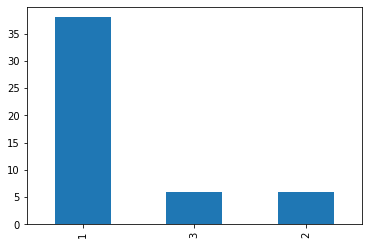

In [ ]:
sot_dataset = load_dataset("ought/raft", "semiconductor_org_types")

train_df = pd.DataFrame(list(zip(sot_dataset['train']['Organization name'] ,sot_dataset['train']['Label'])), 
               columns =['text', 'label'])

test_df = pd.DataFrame(list(zip(sot_dataset['test']['Organization name'] ,sot_dataset['test']['Label'])), 
               columns =['text', 'label'])

x_train = train_df.text.values.tolist()
y_train = train_df.label.values

x_test = test_df.text.values.tolist()

train_df.label.value_counts().plot.bar()

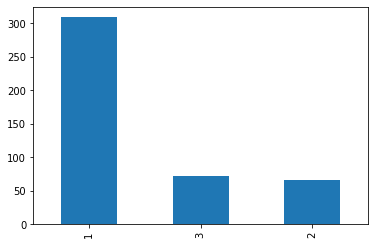

In [ ]:
#SOT Evaluation

eval_df = pd.read_csv('/gdrive/My Drive/DataSet/FART/SOT/sot_test.csv')

x_eval = eval_df.text.values.tolist()
y_eval = eval_df.label.values

eval_df.label.value_counts().plot.bar()

Systematic review inclusion - no eval

In [ ]:
sri_dataset = load_dataset("ought/raft", "systematic_review_inclusion")


train_df = pd.DataFrame(list(zip(sri_dataset['train']['Title'], sri_dataset['train']['Abstract'], sri_dataset['train']['Journal']  ,sri_dataset['train']['Label'])), 
               columns =['Title', 'text', 'Journal', 'label'])

test_df = pd.DataFrame(list(zip(sri_dataset['test']['Abstract'] ,sri_dataset['test']['Label'])), 
               columns =['text', 'label'])


train_df.text=train_df.text.apply(lambda x: ' '.join(x.split(' ')[:128]))

x_train = train_df.text.values.tolist()
y_train = train_df.label.values.tolist()

test_df.text=test_df.text.apply(lambda x: ' '.join(x.split(' ')[:128]))

x_test = test_df.text.values.tolist()

train_df.label.value_counts().plot.bar()

In [ ]:
sri_dataset

DatasetDict({
    train: Dataset({
        features: ['Title', 'Abstract', 'Authors', 'Journal', 'ID', 'Label'],
        num_rows: 50
    })
    test: Dataset({
        features: ['Title', 'Abstract', 'Authors', 'Journal', 'ID', 'Label'],
        num_rows: 2243
    })
})

TAI safety reaserch - no evaluation
https://www.dropbox.com/s/1seagzaas112b1w/TAI-Safety-Bibliography-clean-2020-DEC-21.csv?dl=0

Reusing dataset raft (/root/.cache/huggingface/datasets/ought___raft)/tai_safety_research/1.1.0/79c4de1312c1e3730043f7db07179c914f48403101f7124e2fe336f6f54d9f84)


  0%|          | 0/2 [00:00<?, ?it/s]

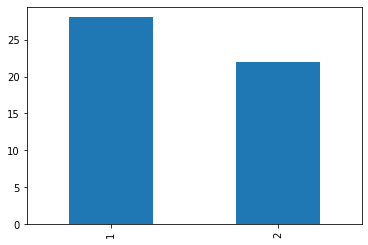

In [ ]:
tai_dataset = load_dataset("ought/raft", "tai_safety_research")


train_df = pd.DataFrame(list(zip(tai_dataset['train']['Abstract Note'], tai_dataset['train']['Label'])), 
               columns =['text', 'label'])

test_df = pd.DataFrame(list(zip(tai_dataset['test']['Abstract Note'] ,tai_dataset['test']['Label'])), 
               columns =['text', 'label'])

train_df.text=train_df.text.apply(lambda x: ' '.join(x.split(' ')[:128]))
x_train = train_df.text.values.tolist()
y_train = train_df.label.values

test_df.text=test_df.text.apply(lambda x: ' '.join(x.split(' ')[:128]))
x_test = test_df.text.values.tolist()

train_df.label.value_counts().plot.bar()

In [ ]:
train_df.to_csv('/gdrive/My Drive/DataSet/FART/TAI/tai_train.csv')

In [ ]:
"hi world".split()

['hi', 'world']

In [ ]:
tai_dataset

DatasetDict({
    train: Dataset({
        features: ['Title', 'Abstract Note', 'Url', 'Publication Year', 'Item Type', 'Author', 'Publication Title', 'ID', 'Label'],
        num_rows: 50
    })
    test: Dataset({
        features: ['Title', 'Abstract Note', 'Url', 'Publication Year', 'Item Type', 'Author', 'Publication Title', 'ID', 'Label'],
        num_rows: 1639
    })
})

Term of Srvice(Tos)

Reusing dataset raft (/root/.cache/huggingface/datasets/ought___raft)/terms_of_service/1.1.0/79c4de1312c1e3730043f7db07179c914f48403101f7124e2fe336f6f54d9f84)


  0%|          | 0/2 [00:00<?, ?it/s]

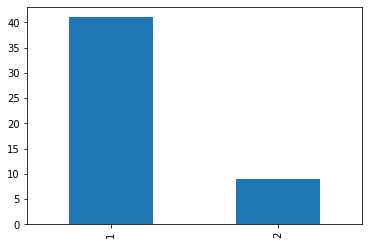

In [ ]:
tos_dataset = load_dataset("ought/raft", "terms_of_service")


train_df = pd.DataFrame(list(zip(tos_dataset['train']['Sentence'] ,tos_dataset['train']['Label'])), 
               columns =['text', 'label'])

test_df = pd.DataFrame(list(zip(tos_dataset['test']['Sentence'] ,tos_dataset['test']['Label'])), 
               columns =['text', 'label'])


x_train = train_df.text.values.tolist()
y_train = train_df.label.values

x_test = test_df.text.values.tolist()


train_df.label.value_counts().plot.bar()

TweetEval Hate (TEH)

Reusing dataset raft (/root/.cache/huggingface/datasets/ought___raft)/tweet_eval_hate/1.1.0/79c4de1312c1e3730043f7db07179c914f48403101f7124e2fe336f6f54d9f84)


  0%|          | 0/2 [00:00<?, ?it/s]

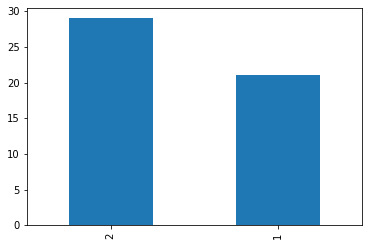

In [ ]:
teh_dataset = load_dataset("ought/raft", "tweet_eval_hate")


train_df = pd.DataFrame(list(zip(teh_dataset['train']['Tweet'] ,teh_dataset['train']['Label'])), 
               columns =['text', 'label'])

test_df = pd.DataFrame(list(zip(teh_dataset['test']['Tweet'] ,teh_dataset['test']['Label'])), 
               columns =['text', 'label'])


x_train = train_df.text.values.tolist()

#train_df.label=train_df.label.replace(2,0)
#train_df.label=train_df.label.replace(1,1)

y_train = train_df.label.values

x_test = test_df.text.values.tolist()


train_df.label.value_counts().plot.bar()

In [ ]:
#TEH Evaluation

eval_df = pd.read_csv('/gdrive/My Drive/DataSet/FART/HateSpeech/hate/train_hate.csv', header=None)

eval_df_sample=eval_df.sample(2966)

In [ ]:
eval_df_sample[1] = eval_df_sample[1].replace([0,1], [2,1])

In [ ]:
x_eval = eval_df_sample[0].values.tolist()
y_eval = eval_df_sample[1].values

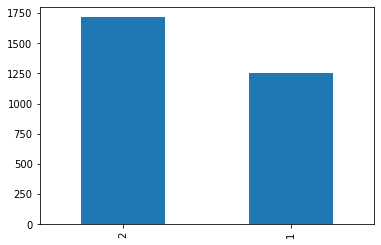

In [ ]:
eval_df_sample[1].value_counts().plot.bar()

Tweitter compaints (TC)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset raft downloaded and prepared to /root/.cache/huggingface/datasets/ought___raft)/twitter_complaints/1.1.0/79c4de1312c1e3730043f7db07179c914f48403101f7124e2fe336f6f54d9f84. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

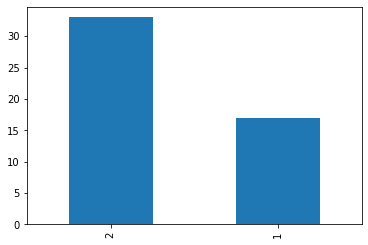

In [ ]:
tc_dataset = load_dataset("ought/raft", "twitter_complaints")


train_df = pd.DataFrame(list(zip(tc_dataset['train']['Tweet text'] ,tc_dataset['train']['Label'])), 
               columns =['text', 'label'])

test_df = pd.DataFrame(list(zip(tc_dataset['test']['Tweet text'] ,tc_dataset['test']['Label'])), 
               columns =['text', 'label'])


x_train = train_df.text.values.tolist()

#train_df.label=train_df.label.replace(2,0)
#train_df.label=train_df.label.replace(1,1)

y_train = train_df.label.values

x_test = test_df.text.values.tolist()


train_df.label.value_counts().plot.bar()

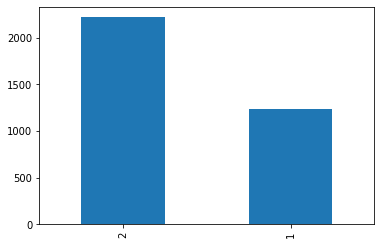

In [ ]:
#TC Evaluation
eval_df = pd.read_csv('/gdrive/My Drive/DataSet/FART/Complaints-data/complaints-data.csv', header=None)

eval_df[2] = eval_df[2].replace([0,1], [2,1])

x_eval = eval_df[1].values.tolist()
y_eval = eval_df[2].values

eval_df[2].value_counts().plot.bar()

In [ ]:
eval_df = pd.read_csv('/gdrive/My Drive/DataSet/FART/Complaints-data/complaints-data.csv', header=None)

In [ ]:
#RTE
!pip install datasets
from datasets import load_dataset
import pandas as pd

rte_dataset = load_dataset('glue','rte')

train_df = pd.DataFrame(list(zip(rte_dataset['train']['label'], rte_dataset['train']['sentence1'], rte_dataset['train']['sentence2'])), 
               columns =['label', 'sentence1', 'sentence2'])

test_df = pd.DataFrame(list(zip(rte_dataset['test']['label'], rte_dataset['test']['sentence1'], rte_dataset['test']['sentence2'])), 
               columns =['label', 'sentence1', 'sentence2'])

set_seed(42)

# Sample by class 
train_df_sample = pd.concat([train_df[train_df.label==0].sample(16), train_df[train_df.label==1].sample(16)])

x_train_q1 = train_df_sample.sentence1.values
x_train_q2 = train_df_sample.sentence2.values
x_train_q1_q2 = np.concatenate((x_train_q1, x_train_q2), axis=0)

# Get the lists of sentences and their labels.
x_train = train_df_sample.sentence1.values+' '+train_df_sample.sentence2.values
y_train = train_df_sample.label.values

x_test_q1 = test_df.sentence1.values
x_test_q2 = test_df.sentence2.values
x_test_q1_q2 = np.concatenate((x_test_q1,x_test_q2), axis=0)

x_test = test_df.sentence1.values+' '+test_df.sentence2.values
y_test = test_df.label.values


In [ ]:
train_df['doc_len'] = train_df.text.apply(lambda words: len(words.split()))

In [ ]:
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


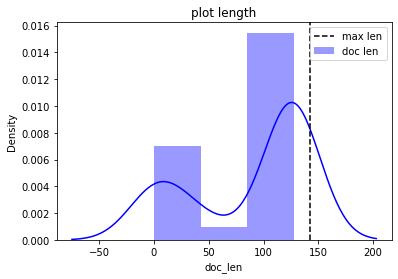

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

# RAFT Benchmark


In [ ]:
!pip install sentence_transformers

     |████████████████████████████████| 78 kB 2.6 MB/s 
     |████████████████████████████████| 2.9 MB 7.7 MB/s 
     |████████████████████████████████| 3.3 MB 55.0 MB/s 
     |████████████████████████████████| 1.2 MB 81.6 MB/s 
     |████████████████████████████████| 895 kB 65.7 MB/s 
     |████████████████████████████████| 596 kB 67.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=3c8a4dabf4b18f2ee10818d235edf9ecf1c8e99046d95ade1ec8d0d4897f00c8
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader

In [ ]:
#labels = np.array(y_train)
#sentences = np.array(x_train)

#numClasses = len(np.unique(labels))
#idx = [np.where(labels == i)[0] for i in range(0, numClasses)]

#for i in range(0, numClasses):
#  idxs = np.where(np.array(labels) == i)[0]
#  print("{}: {} {}".format(i, len(idxs), idxs))

In [ ]:
def make_pairs(sentences, labels, pairs):
	# initialize two empty lists to hold the (sentence, sentence) pairs and
	# labels to indicate if a pair is positive or negative

  numClasses = len(np.unique(labels))
  idx = [np.where(labels == i)[0] for i in range(0, numClasses)]

  for idxA in range(len(sentences)):      
    currentSentence = sentences[idxA]
    label = labels[idxA]
    idxB = np.random.choice(idx[label])
    posSentence = sentences[idxB]
		  # prepare a positive pair and update the sentences and labels
		  # lists, respectively
    pairs.append(InputExample(texts=[currentSentence, posSentence], label=1.0))

    negIdx = np.where(labels != label)[0]
    negSentence = sentences[np.random.choice(negIdx)]
		  # prepare a negative pair of images and update our lists
    pairs.append(InputExample(texts=[currentSentence, negSentence], label=0.0))
  
	# return a 2-tuple of our image pairs and labels
  return (pairs)


In [ ]:
def make_pairs_update(sentences, labels, pairs):
	# initialize two empty lists to hold the (sentence, sentence) pairs and
	# labels to indicate if a pair is positive or negative

  numClassesList = np.unique(labels)
  idx = [np.where(labels == i)[0] for i in numClassesList]

  for idxA in range(len(sentences)):      
    currentSentence = sentences[idxA]
    label = labels[idxA]
    idxB = np.random.choice(idx[np.where(numClassesList==label)[0][0]])
    posSentence = sentences[idxB]
		  # prepare a positive pair and update the sentences and labels
		  # lists, respectively
    pairs.append(InputExample(texts=[currentSentence, posSentence], label=1.0))

    negIdx = np.where(labels != label)[0]
    negSentence = sentences[np.random.choice(negIdx)]
		  # prepare a negative pair of images and update our lists
    pairs.append(InputExample(texts=[currentSentence, negSentence], label=0.0))
  
	# return a 2-tuple of our image pairs and labels
  return (pairs)


In [ ]:
def make_eval_pairs(sentences, labels):
	# initialize two empty lists to hold the (sentence, sentence) pairs and
	# labels to indicate if a pair is positive or negative

  sentences1 = []
  sentences2 = []
  scores = []


  numClasses = len(np.unique(labels))
  idx = [np.where(labels == i)[0] for i in range(0, numClasses)]

  for idxA in range(len(sentences)):      
    currentSentence = sentences[idxA]
    label = labels[idxA]
    idxB = np.random.choice(idx[label])
    posSentence = sentences[idxB]
		  # prepare a positive pair and update the sentences and labels
		  # lists, respectively
    sentences1.append(currentSentence)
    sentences2.append(posSentence)
    scores.append(1.0)

    negIdx = np.where(labels != label)[0]
    negSentence = sentences[np.random.choice(negIdx)]
		  # prepare a negative pair of images and update our lists

    sentences1.append(currentSentence)
    sentences2.append(posSentence)
    scores.append(0.0)
  
	# return a 2-tuple of our image pairs and labels
  return (sentences1, sentences2, scores)

In [ ]:
train_examples = []
train_examples = make_pairs_update(np.array(x_train), np.array(y_train), train_examples)

In [ ]:
#train_examples = []
train_examples = make_pairs_update(np.array(x_train), np.array(y_train), train_examples)

In [ ]:
#sentences1, sentences2, labels = make_eval_pairs(np.array(x_test), np.array(y_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  app.launch_new_instance()


In [ ]:
#evaluator = evaluation.EmbeddingSimilarityEvaluator(sentences1, sentences2, labels, show_progress_bar=True)
#evaluator = evaluation.BinaryClassificationEvaluator(sentences1, sentences2, labels, show_progress_bar=True)

In [ ]:
#!pip install simcse
#from simcse import SimCSE
#model = SimCSE("princeton-nlp/sup-simcse-bert-base-uncased") # 
#model = SimCSE("princeton-nlp/sup-simcse-roberta-base") # 83 SST2
#model = SimCSE("princeton-nlp/sup-simcse-roberta-large") # 

In [ ]:
#Define the model. Either from scratch of by loading a pre-trained model
model = SentenceTransformer('paraphrase-mpnet-base-v2') #91.2
#model = SentenceTransformer('roberta-base-nli-stsb-mean-tokens') # 85
#model = SentenceTransformer('all-mpnet-base-v2')  # 90
#model = SentenceTransformer('bert-base-nli-cls-token') #82
#model = SentenceTransformer('stsb-roberta-large') # No memory allocated
#model = SentenceTransformer('stsb-mpnet-base-v2') # 89
 

#Define your train examples. You need more than just two examples...
#train_examples = [InputExample(texts=['My first sentence', 'My second sentence'], label=0.8),
#    InputExample(texts=['Another pair', 'Unrelated sentence'], label=0.3)]

#Define your train dataset, the dataloader and the train loss
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

#https://www.sbert.net/docs/package_reference/losses.html
train_loss = losses.CosineSimilarityLoss(model)

#Tune the model
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=3, warmup_steps=10, show_progress_bar=True)

Evaluate the results - Original model

In [ ]:
#Define the model. Either from scratch of by loading a pre-trained model
orig_model = SentenceTransformer('paraphrase-mpnet-base-v2')

In [ ]:
X_train = orig_model.encode(x_train)
X_eval = orig_model.encode(x_eval)

Evaluate the results - Fine-tuned model

In [ ]:
X_train = model.encode(x_train)
X_eval = model.encode(x_eval)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

sgd =  LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()


sgd.fit(X_train, y_train)
knn.fit(X_train, y_train)
svc.fit(X_train, y_train)


y_pred_eval_knn = knn.predict(X_eval)
y_pred_eval_svc = svc.predict(X_eval)
y_pred_eval_sgd = sgd.predict(X_eval)

acc_knn = f1_score(y_eval, y_pred_eval_knn, average='weighted')
acc_svc = f1_score(y_eval, y_pred_eval_svc, average='weighted')
acc_sgd = f1_score(y_eval, y_pred_eval_sgd, average='weighted')

print(f'KNN accuracy = {acc_knn}, SVC accuracy = {acc_svc}, SGD accuracy = {acc_sgd}')

KNN accuracy = 0.8482165208817928, SVC accuracy = 0.8484939338670439, SGD accuracy = 0.8508531901021367


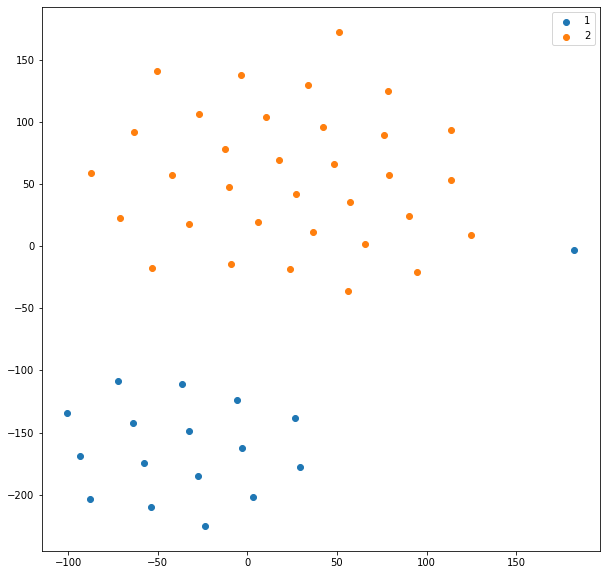

In [ ]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

X_embedded = TSNE(n_components=2).fit_transform(np.array(X_train))

plt.figure(figsize=(10,10))

for i, t in enumerate(set(np.array(y_train))):
    idx = np.array(y_train) == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

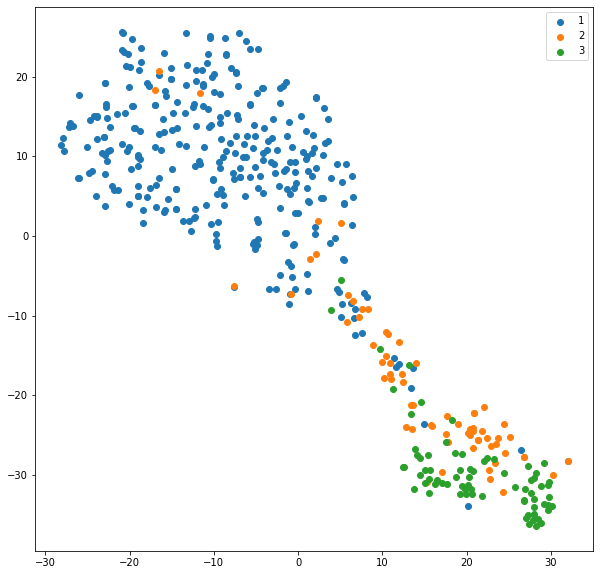

In [ ]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

X_embedded = TSNE(n_components=2).fit_transform(np.array(X_eval))

plt.figure(figsize=(10,10))

for i, t in enumerate(set(np.array(y_eval))):
    idx = np.array(y_eval) == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

Save to pediction.csv

In [ ]:
#['ade_corpus_v2',  ade_dataset
# 'banking_77',     b77_dataset
# 'neurips_impact_statement_risks', nis_dataset
# 'one_stop_english',     ose_dataset
# 'overruling',                  over_dataset
# 'semiconductor_org_types'.  sot_dataset]
# 'systematic_review_inclusion',  sri_dataset
# 'tai_safety_research',  tai_dataset 
# 'terms_of_service', tos_dataset
# 'tweet_eval_hate',      teh_dataset
# 'twitter_complaints',   tc_dataset

In [ ]:
gpath = '/gdrive/My Drive/DataSet/FART/data'

In [ ]:
task = 'twitter_complaints'
dataset = tc_dataset

In [ ]:
X_test = model.encode(x_test)

In [ ]:
y_test_pred_sgd = sgd.predict(X_test)

In [ ]:
test_df['Label'] = y_test_pred_sgd

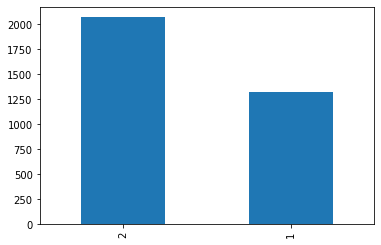

In [ ]:
test_df['Label'].value_counts().plot.bar()

In [ ]:
preds = pd.read_csv(f"{gpath}/{task}/predictions.csv")

In [ ]:
 preds["Label"] = dataset['train'].features['Label'].int2str(y_test_pred_sgd)

In [ ]:
 preds.to_csv(f"{gpath}/{task}/predictions1.csv", index=False)

# SST-2 vs. #sample

In [ ]:
#SST-2
# Load the dataset into a pandas dataframe.

train_df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

# Load the test dataset into a pandas dataframe.
test_df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/test.tsv', delimiter='\t', header=None)

set_seed(42)


# Sample by class 
train_df_sample = pd.concat([train_df[train_df[1]==0].sample(16), train_df[train_df[1]==1].sample(16)])
#train_df_sample = train_df.sample(128)

text_col=train_df.columns.values[0] 
category_col=train_df.columns.values[1]

x_train = train_df_sample[text_col].values.tolist()
x_test = test_df[text_col].values.tolist()

y_train = train_df_sample[category_col].values.tolist()
y_test = test_df[category_col].values.tolist()

#train_df_GLUE = pd.read_csv('/gdrive/My Drive/DataSet/GLUE/SST-2/SST-2/train.tsv', delimiter='\t')
#train_df_sample = pd.concat([train_df_GLUE[train_df_GLUE.label==0].sample(10000), train_df_GLUE[train_df_GLUE.label==1].sample(10000)])
#rain_df_sample = train_df_GLUE.sample(10000)

#x_train = train_df_sample.sentence.values.tolist()
#y_train= train_df_sample.label.values.tolist()

#train_df_sample.label.value_counts().plot.bar()

In [ ]:
train_df_GLUE

,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates som...,1
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0
...,...,...
67344,a delightful comedy,1
67345,"anguish , anger and frustration",0
67346,"at achieving the modest , crowd-pleasing goals...",1
67347,a patient viewer,1


In [ ]:
def make_pairs_update(sentences, labels, pairs):
	# initialize two empty lists to hold the (sentence, sentence) pairs and
	# labels to indicate if a pair is positive or negative

  numClassesList = np.unique(labels)
  idx = [np.where(labels == i)[0] for i in numClassesList]

  for idxA in range(len(sentences)):      
    currentSentence = sentences[idxA]
    label = labels[idxA]
    idxB = np.random.choice(idx[np.where(numClassesList==label)[0][0]])
    posSentence = sentences[idxB]
		  # prepare a positive pair and update the sentences and labels
		  # lists, respectively
    pairs.append(InputExample(texts=[currentSentence, posSentence], label=1.0))

    negIdx = np.where(labels != label)[0]
    negSentence = sentences[np.random.choice(negIdx)]
		  # prepare a negative pair of images and update our lists
    pairs.append(InputExample(texts=[currentSentence, negSentence], label=0.0))
  
	# return a 2-tuple of our image pairs and labels
  return (pairs)

In [ ]:
!pip install sentence_transformers

     |████████████████████████████████| 78 kB 4.4 MB/s 
     |████████████████████████████████| 2.9 MB 30.2 MB/s 
     |████████████████████████████████| 3.3 MB 32.5 MB/s 
     |████████████████████████████████| 1.2 MB 58.6 MB/s 
     |████████████████████████████████| 596 kB 60.4 MB/s 
     |████████████████████████████████| 895 kB 41.1 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=5a7f635032cbb921d58fda57b5cc41cc64cbaa84bfd6382bc91cf578ac78f86d
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader


In [ ]:
train_examples = []
train_examples = make_pairs_update(np.array(x_train), np.array(y_train), train_examples)

In [ ]:
train_examples = make_pairs_update(np.array(x_train), np.array(y_train), train_examples)
train_examples = make_pairs_update(np.array(x_train), np.array(y_train), train_examples)
train_examples = make_pairs_update(np.array(x_train), np.array(y_train), train_examples)
train_examples = make_pairs_update(np.array(x_train), np.array(y_train), train_examples)

In [ ]:
len(train_examples)

320

In [ ]:
#Define the model. Either from scratch of by loading a pre-trained model
model = SentenceTransformer('paraphrase-mpnet-base-v2') #91.2
#model = SentenceTransformer('/gdrive/My Drive/SimCSE/simcse-model')
#model = SentenceTransformer('roberta-base-nli-stsb-mean-tokens') # 85
#model = SentenceTransformer('all-mpnet-base-v2')  # 90
#model = SentenceTransformer('bert-base-nli-cls-token') #82
#model = SentenceTransformer('stsb-roberta-large') # No memory allocated
#model = SentenceTransformer('stsb-mpnet-base-v2') # 89
#model = SentenceTransformer('all-MiniLM-L6-v2') # 82



#model_name = 'distilroberta-base'
#word_embedding_model = models.Transformer(model_name, max_seq_length=32)
#pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
#model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

#Define your train examples. You need more than just two examples...
#train_examples = [InputExample(texts=['My first sentence', 'My second sentence'], label=0.8),
#    InputExample(texts=['Another pair', 'Unrelated sentence'], label=0.3)]

#Define your train dataset, the dataloader and the train loss
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

#https://www.sbert.net/docs/package_reference/losses.html
train_loss = losses.CosineSimilarityLoss(model)
#train_loss = losses.MultipleNegativesRankingLoss(model)

#Tune the model
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=3, warmup_steps=10, show_progress_bar=True)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Orig Model

In [ ]:
#Define the model. Either from scratch of by loading a pre-trained model
orig_model = SentenceTransformer('paraphrase-mpnet-base-v2')

In [ ]:
X_train = orig_model.encode(x_train)
X_test = orig_model.encode(x_test)

Siam Model

In [ ]:
X_train = model.encode(x_train)
X_test = model.encode(x_test)

Evaluate

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

sgd =  LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
svc = LinearSVC()


sgd.fit(X_train, y_train)
knn.fit(X_train, y_train)
svc.fit(X_train, y_train)


y_pred_knn = knn.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_sgd = sgd.predict(X_test)

acc_knn = accuracy_score(y_test, y_pred_knn)
acc_svc = accuracy_score(y_test, y_pred_svc)
acc_sgd = accuracy_score(y_test, y_pred_sgd)

print(f'KNN accuracy = {acc_knn}, SVC accuracy = {acc_svc}, SGD accuracy = {acc_sgd}')

KNN accuracy = 0.8956617243272927, SVC accuracy = 0.8956617243272927, SGD accuracy = 0.8956617243272927


Plot

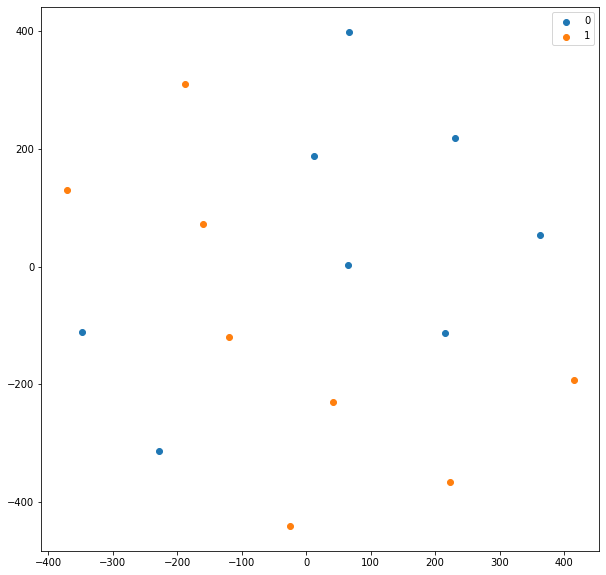

In [ ]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

X_embedded = TSNE(n_components=2).fit_transform(np.array(X_train))

plt.figure(figsize=(10,10))

for i, t in enumerate(set(np.array(y_train))):
    idx = np.array(y_train) == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

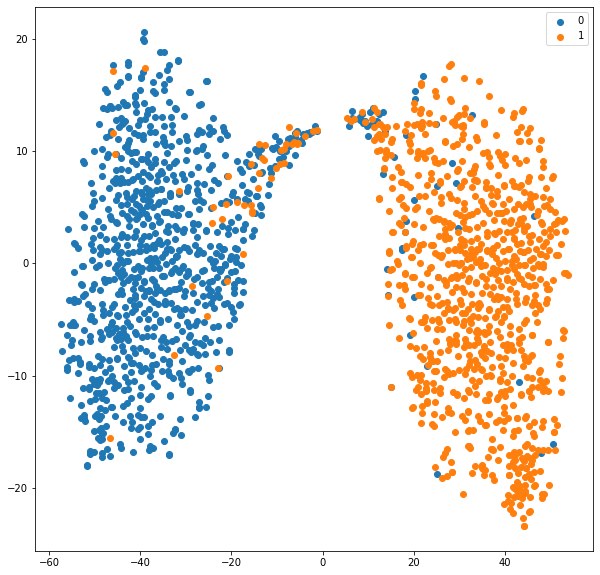

In [ ]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

X_embedded = TSNE(n_components=2).fit_transform(np.array(X_test))

plt.figure(figsize=(10,10))

for i, t in enumerate(set(np.array(y_test))):
    idx = np.array(y_test) == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

# Validate data 

In [ ]:
!pip install datasets

ERROR: Operation cancelled by user


In [ ]:
import datetime
import re
import subprocess
from pathlib import Path

import pandas as pd
from datasets import get_dataset_config_names, load_dataset

In [ ]:
CSV_SCHEMA = {
    "banking_77": (5000, 2),
    "overruling": (2350, 2),
    "semiconductor_org_types": (449, 2),
    "ade_corpus_v2": (5000, 2),
    "twitter_complaints": (3399, 2),
    "neurips_impact_statement_risks": (150, 2),
    "systematic_review_inclusion": (2243, 2),
    "terms_of_service": (5000, 2),
    "tai_safety_research": (1639, 2),
    "one_stop_english": (516, 2),
    "tweet_eval_hate": (2966, 2),
}


In [ ]:
tasks = get_dataset_config_names("ought/raft")

In [ ]:
gpath = '/gdrive/My Drive/DataSet/FART/data'

In [ ]:
prediction_files = list(Path(gpath).rglob("predictions1.csv"))

In [ ]:
mismatched_files = set(tasks).symmetric_difference(set([f.parent.name for f in prediction_files]))

In [ ]:
mismatched_files

set()

In [ ]:
shape_errors = []
column_errors = []
for prediction_file in prediction_files:
    df = pd.read_csv(prediction_file)
    incorrect_shape = df.shape != CSV_SCHEMA[prediction_file.parent.name]
    if incorrect_shape:
        shape_errors.append(prediction_file)
    incorrect_columns = sorted(df.columns) != ["ID", "Label"]
    if incorrect_columns:
        column_errors.append(prediction_file)

In [ ]:
shape_errors

[]

In [ ]:
incorrect_columns

False

In [ ]:
moshew/my_raft

In [ ]:
!pip install datasets
from datasets import load_dataset

In [ ]:
    # Check we can load the dataset for each task
load_errors = []
for task in tasks:
      try:
          _ = load_dataset("moshew/my_raft", task)
      except Exception as e:
          load_errors.append(e)

In [ ]:
load_errors

[]

# SST-2 vs. Unsupervised

In [ ]:
#SST-2
# Load the dataset into a pandas dataframe.

train_df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

# Load the test dataset into a pandas dataframe.
test_df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/test.tsv', delimiter='\t', header=None)

set_seed(42)


# Sample by class 
#train_df_sample = pd.concat([train_df[train_df[1]==0].sample(32), train_df[train_df[1]==1].sample(32)])
train_df_sample = train_df.sample(2000)

text_col=train_df.columns.values[0] 
category_col=train_df.columns.values[1]

x_train = train_df_sample[text_col].values.tolist()
x_test = test_df[text_col].values.tolist()

y_train = train_df_sample[category_col].values.tolist()
y_test = test_df[category_col].values.tolist()

#train_df_GLUE = pd.read_csv('/gdrive/My Drive/DataSet/GLUE/SST-2/SST-2/train.tsv', delimiter='\t')
#train_df_sample = pd.concat([train_df_GLUE[train_df_GLUE.label==0].sample(10000), train_df_GLUE[train_df_GLUE.label==1].sample(10000)])
#rain_df_sample = train_df_GLUE.sample(10000)

#x_train = train_df_sample.sentence.values.tolist()
#y_train= train_df_sample.label.values.tolist()

#train_df_sample.label.value_counts().plot.bar()

In [ ]:
def make_pairs_update(sentences, labels, pairs):
	# initialize two empty lists to hold the (sentence, sentence) pairs and
	# labels to indicate if a pair is positive or negative

  numClassesList = np.unique(labels)
  idx = [np.where(labels == i)[0] for i in numClassesList]

  for idxA in range(len(sentences)):      
    currentSentence = sentences[idxA]
    label = labels[idxA]
    idxB = np.random.choice(idx[np.where(numClassesList==label)[0][0]])
    posSentence = sentences[idxB]
		  # prepare a positive pair and update the sentences and labels
		  # lists, respectively
    pairs.append(InputExample(texts=[currentSentence, posSentence], label=1.0))

    negIdx = np.where(labels != label)[0]
    negSentence = sentences[np.random.choice(negIdx)]
		  # prepare a negative pair of images and update our lists
    pairs.append(InputExample(texts=[currentSentence, negSentence], label=0.0))
  
	# return a 2-tuple of our image pairs and labels
  return (pairs)

In [ ]:
!pip install sentence_transformers

     |████████████████████████████████| 78 kB 4.4 MB/s 
     |████████████████████████████████| 2.9 MB 30.2 MB/s 
     |████████████████████████████████| 3.3 MB 32.5 MB/s 
     |████████████████████████████████| 1.2 MB 58.6 MB/s 
     |████████████████████████████████| 596 kB 60.4 MB/s 
     |████████████████████████████████| 895 kB 41.1 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=5a7f635032cbb921d58fda57b5cc41cc64cbaa84bfd6382bc91cf578ac78f86d
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation, SentencesDataset
from torch.utils.data import DataLoader
import math


In [ ]:
train_examples = []
train_examples = [InputExample(texts=[s, s]) for s in x_train]

In [ ]:
#Define the model. Either from scratch of by loading a pre-trained model
model = SentenceTransformer('paraphrase-mpnet-base-v2') #91.2
#model = SentenceTransformer('/gdrive/My Drive/SimCSE/simcse-model')

#model_name = 'distilroberta-base'
#word_embedding_model = models.Transformer(model_name, max_seq_length=32)
#pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
#model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

#Define your train examples. You need more than just two examples...
#train_examples = [InputExample(texts=['My first sentence', 'My second sentence'], label=0.8),
#    InputExample(texts=['Another pair', 'Unrelated sentence'], label=0.3)]

#train_dataset = SentencesDataset(train_examples, model)

#Define your train dataset, the dataloader and the train loss
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=128)

num_epochs = 3

warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up

#https://www.sbert.net/docs/package_reference/losses.html
#train_loss = losses.CosineSimilarityLoss(model)
train_loss = losses.MultipleNegativesRankingLoss(model)

#Tune the model
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=num_epochs, warmup_steps=warmup_steps, show_progress_bar=True)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Siam Model

In [ ]:
X_train = model.encode(x_train)
X_test = model.encode(x_test)

Evaluate

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture

kmeans =  KMeans(n_clusters=2)
gmm = GaussianMixture()
minikm =  MiniBatchKMeans(n_clusters=2)

kmeans.fit(X_train)
gmm.fit(X_train)
minikm.fit(X_train)

y_pred_kmeans = kmeans.predict(X_test)
y_pred_gmm = gmm.predict(X_test)
y_pred_minikm = minikm.predict(X_test)

acc_knn = accuracy_score(y_test, y_pred_kmeans)
acc_svc = accuracy_score(y_test, y_pred_gmm)
acc_minikm = accuracy_score(y_test, y_pred_minikm)

print(f'kmeans accuracy = {acc_knn}, GMM accuracy = {acc_svc}, minikm accuracy = {acc_minikm}')

kmeans accuracy = 0.1356397583745195, GMM accuracy = 0.500823723228995, minikm accuracy = 0.442613948380011


Plot

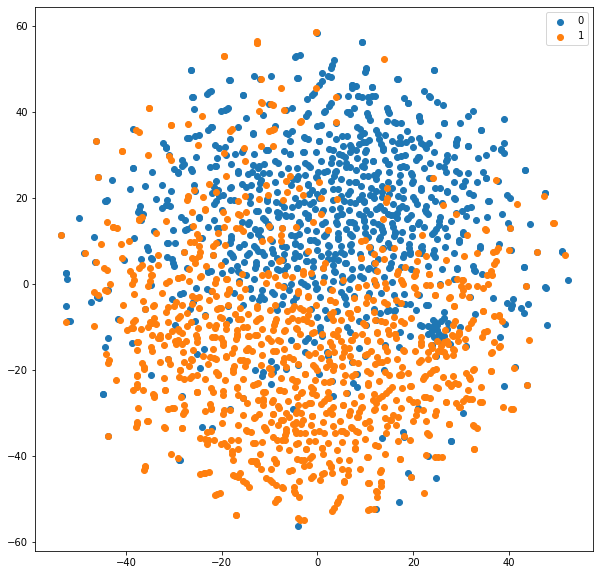

In [ ]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

X_embedded = TSNE(n_components=2).fit_transform(np.array(X_train))

plt.figure(figsize=(10,10))

for i, t in enumerate(set(np.array(y_train))):
    idx = np.array(y_train) == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

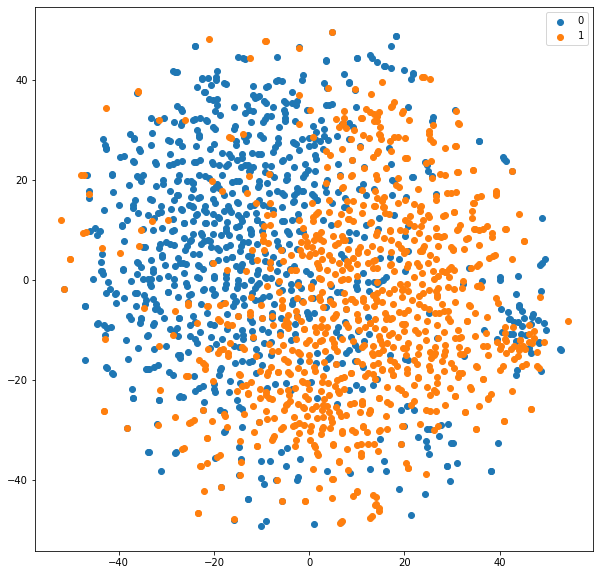

In [ ]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

X_embedded = TSNE(n_components=2).fit_transform(np.array(X_test))

plt.figure(figsize=(10,10))

for i, t in enumerate(set(np.array(y_test))):
    idx = np.array(y_test) == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));